In [1]:
from skimage import io
from skimage.color import rgb2gray
from skimage import draw
import numpy as np
from typing import Tuple, List, Annotated
import math
import cv2
import operator

In [2]:
# Given an index of a pixel, a measurement and a theta, return the endpoint
def get_endpoint(position: Tuple[int, int], measurement: float, theta: float, map_shape: Tuple[int, int]):
    endpoint = (
        math.floor(position[0] + measurement * math.cos(math.radians(theta))),
        math.floor(position[1] + measurement * math.sin(math.radians(theta)))
    )

    # Sometimes, we get a coordinate endpoint == the shape of the field
    # which results in out of range indexing, even though we are using math.floor() in the 
    # above. Here, we prevent that by setting it to max dimension - 1

    if endpoint[1] >= map_shape[1]:
        endpoint = (endpoint[0], map_shape[1] - 1)

    if endpoint[0] >= map_shape[0]:
        endpoint = (map_shape[0] - 1, endpoint[1])

    return endpoint

In [3]:
# This draws a line on the given map, and returns the distance to the endpoint of the line => the measurment 
def draw_line(robot_pose: Tuple[int, int, int], map: np.ndarray, color: float = 0.5) -> float:
    
    max_ray_range = (12*100)/4
    endpoint = get_endpoint(robot_pose[0:2], max_ray_range, robot_pose[2], map.shape)

    indices = draw.line_aa(robot_pose[0], robot_pose[1], endpoint[0], endpoint[1])
    valid_row = indices[0][indices[0] < map.shape[0]]
    valid_col = indices[1][indices[1] < map.shape[1]]
    
    if valid_row.shape[0] > valid_col.shape[0]: valid_row = valid_row[:valid_col.shape[0]]
    else: valid_col = valid_col[:valid_row.shape[0]]

    distance = None

    for row, col in zip(valid_row, valid_col):
        if map[row, col] == 0.0:
            distance = math.sqrt( (robot_pose[0] - row)**2 + (robot_pose[1] - col)**2 )
            break
        else: map[row, col] = color

    if distance is None: distance = math.sqrt( (robot_pose[0] - valid_row[-1])**2 + (robot_pose[1] - valid_col[-1])**2 )
    return distance

In [105]:
# This draws the sensor rays with an opening angle 250, and returns a list of two lists of measurements
# One for the measurements of the 125 degrees to the right, and one for the measurments of the 125 degrees to the left
# This is used later for requirement 2 => providing us with an actual reasonable sample of measurements to work with.
def draw_sensor_rays(robot_pose: Tuple[int, int], map: np.ndarray) -> Annotated[List[List[float]], 3]:

    distances_exact_pose = []
    distances_right = []
    distances_left  = []

    # Drawing the ray cast at the robot's exact pose angle
    distances_exact_pose.append(draw_line(robot_pose, map))
    
    # Drawing rays to the right and the left of the robot (125 right, and 125 left)
    for i in range(2, 125, 2): distances_right.append(draw_line((robot_pose[0], robot_pose[1], robot_pose[2]+i), map))
    for i in range(2, 125, 2): distances_left.append(draw_line((robot_pose[0], robot_pose[1], robot_pose[2]-i), map))

    # Draw the disk representing the robot
    radius = 10
    disk_coordinates = draw.disk(robot_pose[:2], radius)[:]
    valid_row = disk_coordinates[0][disk_coordinates[0] < map.shape[0]]
    valid_col = disk_coordinates[1][disk_coordinates[1] < map.shape[1]]
    for row, col in zip(valid_row, valid_col): map[row, col] = 0.0

    # Drawing a line to indicate the robot's angle
    line_end = get_endpoint(position=robot_pose[:2], measurement=radius+10, theta=robot_pose[2], map_shape=map.shape)
    cv2.line(map, robot_pose[:2][::-1], line_end[::-1], 0.1, 3)

    return [distances_exact_pose, distances_right, distances_left]

In [106]:
def read_binary_map(path: str, reverse: bool = False) -> np.ndarray:
    map = rgb2gray(io.imread(path))
    binary_threshold = 0.5

    map[map < binary_threshold] = 0.0
    map[map > binary_threshold] = 1.0

    if reverse: map = 1.0 - map
    return map

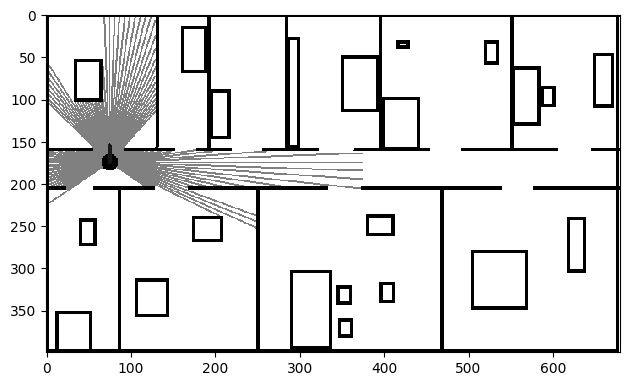

In [107]:
# Requirement 1
req1_map = read_binary_map('Map.jpg')
robot_pose = (175, 75, 180)
req1_measurements = draw_sensor_rays(robot_pose, req1_map)
io.imshow(req1_map)

In [102]:
def fill_obstacles(map: np.ndarray) -> np.ndarray:

    filled_map = map.copy()
    
    contours, _ = cv2.findContours(np.array(filled_map, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        
        # Approximate the contour to check for rectangles
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
        
        # If the contour has 4 corners, draw rectangle
        if len(approx) == 4:

            # Getting the bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)

            # Here, we skip the contours that represents the boundaries of the whole map with a condition:
            # if the width or the hieght is equal to or exceeds the width or the height of the map, respectively.
            if (w >= 0.9 * filled_map.shape[1]) or (h >= 0.9 * filled_map.shape[0]): continue

            # Drawing the filled rectangle 
            cv2.rectangle(filled_map, (x, y), (x + w, y + h), 1, -1)

    return filled_map

In [8]:
def generate_likelihood_field(map: np.ndarray, standard_deviation : float = 1.0) -> np.ndarray:

    # Gaussian equation evaluation.
    likelihood = lambda std, distance: (1 / (math.sqrt(2*math.pi)*std)) * math.exp((-1 * (distance**2))/(2*(std**2))) if (std != 0) \
    else (1 if distance == 0 else 0)

    # This is the field that will be returned
    likelihood_field = map.copy()

    # Getting coordinates of obstacles and non-obstacles
    obstacles = np.argwhere(map == 1.0)
    non_obstacles = np.argwhere(map == 0.0)
    
    # Updating likelihood for non-obstacles
    for non_obstacle in non_obstacles: likelihood_field[non_obstacle[0], non_obstacle[1]] = likelihood(standard_deviation, np.amin(np.linalg.norm(non_obstacle -  obstacles, axis=1)))
    
    # Filling the obstacles in the map before updating the likelihood of the obstacle points
    # This is done here instead of above before calculating distances for non-obstacles, because it'd be inefficient
    # and useless.
    # The number of distances calculated for each non-obstacle to the obstacle points will increase given that we are filling
    # those obstacles. We only care about the distance to the nearest obstacle, which by definition lies on the boundary of the obstacle
    filled_map = fill_obstacles(map)
    obstacles = np.argwhere(filled_map == 1.0)

    for obstacle in obstacles: likelihood_field[obstacle[0], obstacle[1]] = likelihood(standard_deviation, 0)

    return likelihood_field

In [27]:
# Measurements are given in pixels, instead of the meters/cms value of pixels 
def generate_probability_map(measurements: Annotated[List[List[float]], 2], map: np.ndarray, likelihood_field: np.ndarray) -> np.ndarray:

    ops = [operator.add, operator.sub]
    
    probability_map = map.copy()

    # Looping over all potential positions in the map
    for potential_position in np.argwhere(map == 0.0):

        max_probability = float("-inf")

        # Trying all thetas with step 5°
        #for theta in range(0, 5, 360):
        theta = 45 
        # Initializing the product with the likelihood of the endpoint at the angle of the robot's pose
        endpoint_at_exact_angle = get_endpoint(potential_position, measurements[0][0], theta, map_shape=likelihood_field.shape)
        likelihood_product = likelihood_field[endpoint_at_exact_angle[0], endpoint_at_exact_angle[1]]

        for i in range(1, 3, 1):
            for j in range(len(measurements[i])):

                # Obtaining the endpoint given the position, measurement, theta±x where x is from the range 2,4,..,124
                endpoint = get_endpoint(potential_position, measurements[i][j], ops[i-1](theta,(i*2 + 2)), map_shape=likelihood_field.shape)
                likelihood_product *= likelihood_field[endpoint[0], endpoint[1]]

        # If this is greater than the greater product for a theta we have come across so far
        if likelihood_product > max_probability: max_probability = likelihood_product

        # Updating the pixel value with the maximum probability
        probability_map[potential_position[0], potential_position[1]] = max_probability

    return probability_map

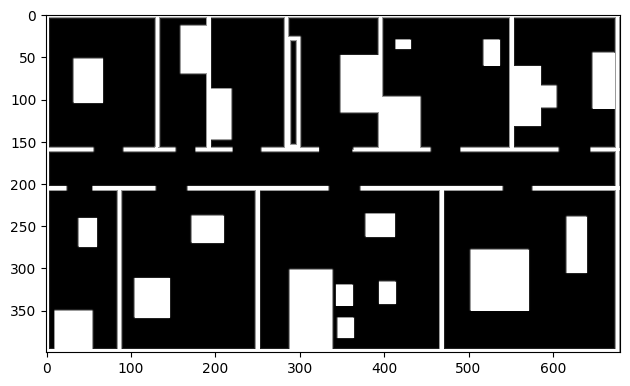

In [10]:
# Requirement 2
# Getting the likelihood field then normalizing it.
# Note: normalizing the likelihood field won't mess up any results, since when it is utilized, it will be in the context
# of probabilities. As long as the values relative to each other are the same, this won't have any effect.
# Also, this helps with high standard deviation, when the data has a low range, and the skimage doesn't show the image correctly.
req2_map = read_binary_map('Map.jpg', True)
likelihood_field = generate_likelihood_field(req2_map, 1)
likelihood_field = likelihood_field / likelihood_field.max()
io.imshow(likelihood_field)

In [28]:
prob_map = generate_probability_map(measurements=req1_measurements, map=fill_obstacles(req2_map), likelihood_field=likelihood_field)

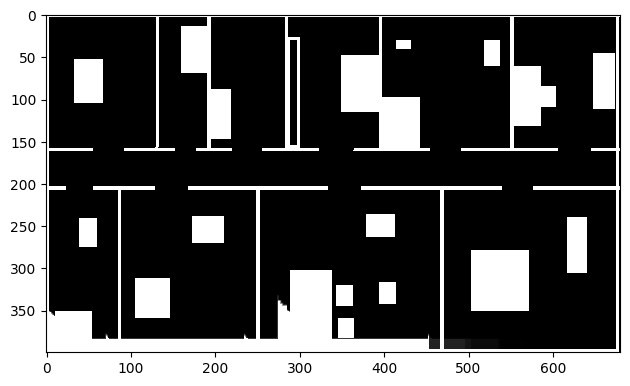

In [30]:
io.imshow(prob_map)

In [26]:
io.imsave('test.jpg', (req1_map * 255).astype(np.uint8))